In [288]:
import numpy as np
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [289]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [290]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Prepare Data

In [402]:
df = pd.read_csv("gaze_labels.csv", index_col = "Participant_ID")

In [403]:
df.head()

,PHQ_Score,PHQ_Binary
Participant_ID,,
300,2,0
301,3,0
302,4,0
303,0,0
304,6,0


In [521]:
# X = np.load("gaze_features.npy")
X = np.load("avg_gaze.npy")
y = df['PHQ_Binary']

In [522]:
# X_f1 = X[:,3:6]
# X_fh0 = X[:,6:9]
# X_fh1 = X[:,9:12]
# X_f01 = X[:,0:6]
# X_fh0h1 = X[:,6:12]

In [523]:
def train_test(X, y, testfile='test_split_Depression_AVEC2017.csv'):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        if participant_no in test_participants:
            X_test.append(X[i])
            y_test.append(y[participant_no])
        else:
            X_train.append(X[i])
            y_train.append(y[participant_no])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [524]:
X_train, X_test, y_train, y_test = train_test(X, y, '../test_split_Depression_AVEC2017.csv')

In [525]:
X_test.shape

(45, 12)

In [502]:
# X_train_f1, X_test_f1, y_train, y_test = train_test(X_f1, y, '../test_split_Depression_AVEC2017.csv')
# X_train_fh0, X_test_fh0, _, _ = train_test(X_fh0, y, '../test_split_Depression_AVEC2017.csv')
# X_train_fh1, X_test_fh1, _, _ = train_test(X_fh1, y, '../test_split_Depression_AVEC2017.csv')
# X_train, X_test, y_train, y_test = train_test(X_fh0h1, y, '../test_split_Depression_AVEC2017.csv')

In [526]:
RANDOM_STATE = 42
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [471]:
# X_train.shape

In [472]:
# X_train, y_train =balance_data(X_train,y_train)

In [473]:
# # the ratio of minority class to majority class will be 1 after resampling
# us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

# X_train, y_train = us.fit_sample(X_train, y_train)

In [474]:
# os = SMOTE() 
# X_train, y_train = os.fit_sample(X_train, y_train)

In [475]:
X_train[0]

array([ 0.0913719 ,  0.21656776, -0.96667616, -0.19744762,  0.22993486,
       -0.9465671 ])

In [527]:
# separate depressed and non-depressed samples to plot
dep = []
non_dep = []
for i in range(y_train.shape[0]):
    if y_train[i] == 1:
        dep.append(X_train[i])
    else:
        non_dep.append(X_train[i])
dep = np.array(dep)
non_dep = np.array(non_dep)

Text(0.5, 0, 'z0')

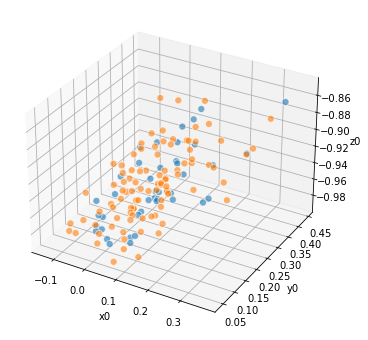

In [528]:
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(111, projection='3d')

xd = dep[:,0]
yd = dep[:,1]
zd = dep[:,2]
ax0.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,0]
yn = non_dep[:,1]
zn = non_dep[:,2]
ax0.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


ax0.set_xlabel('x0')
ax0.set_ylabel('y0')
ax0.set_zlabel('z0')

Text(0.5, 0, 'z1')

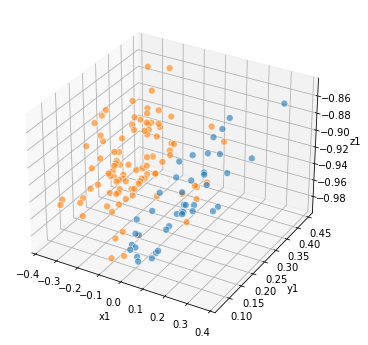

In [529]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')

xd = dep[:,3]
yd = dep[:,4]
zd = dep[:,5]
ax1.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,3]
yn = non_dep[:,4]
zn = non_dep[:,5]
ax1.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


ax1.set_xlabel('x1')
ax1.set_ylabel('y1')
ax1.set_zlabel('z1')

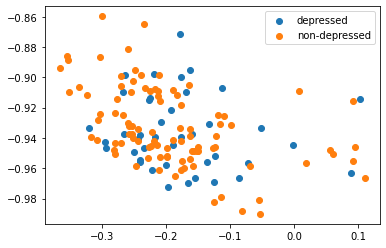

In [530]:
plt.scatter(xd, zd, label='depressed')
plt.scatter(xn, zn, label='non-depressed')
plt.legend()
plt.show()

Text(0.5, 0, 'z_h0')

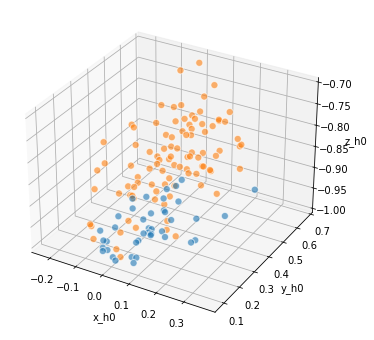

In [531]:
fig = plt.figure(figsize=(8, 6))
axh0 = fig.add_subplot(111, projection='3d')

xd = dep[:,6]
yd = dep[:,7]
zd = dep[:,8]
axh0.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,6]
yn = non_dep[:,7]
zn = non_dep[:,8]
axh0.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


axh0.set_xlabel('x_h0')
axh0.set_ylabel('y_h0')
axh0.set_zlabel('z_h0')

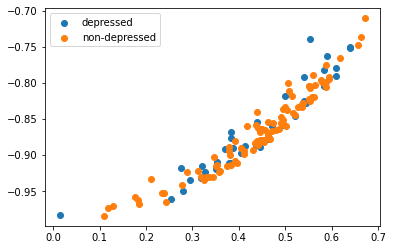

In [532]:
plt.scatter(yd, zd, label='depressed')
plt.scatter(yn, zn, label='non-depressed')
plt.legend()
plt.show()

Text(0.5, 0, 'z_h1')

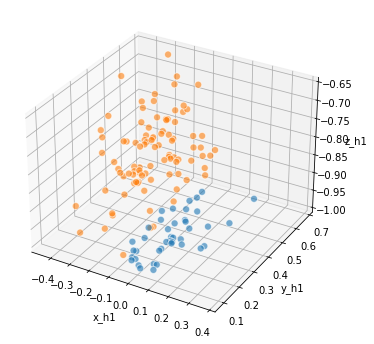

In [533]:
fig = plt.figure(figsize=(8, 6))
axh1 = fig.add_subplot(111, projection='3d')

xd = dep[:,9]
yd = dep[:,10]
zd = dep[:,11]
axh1.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,9]
yn = non_dep[:,10]
zn = non_dep[:,11]
axh1.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


axh1.set_xlabel('x_h1')
axh1.set_ylabel('y_h1')
axh1.set_zlabel('z_h1')

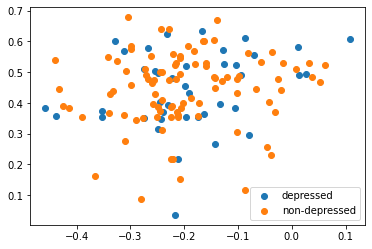

In [534]:
plt.scatter(xd, yd, label='depressed')
plt.scatter(xn, yn, label='non-depressed')
plt.legend()
plt.show()

# Evaluation Metrics

In [535]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

# Neural Network Model

In [536]:
# n_input = X_train.shape[1]
# n_features = X_train.shape[2]
# input_shape = (n_input, n_features)

In [537]:
model = Sequential()
# model.add(LSTM(100, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(50, input_shape=input_shape))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [538]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
checkpoint_filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [539]:
model.fit(X_train, y_train, batch_size=16, epochs=30, validation_split=0.1, callbacks=[es, checkpoint])

Train on 122 samples, validate on 14 samples
Epoch 1/30
122/122 [==============================] - 0s 2ms/step - loss: 0.7026 - accuracy: 0.3361 - val_loss: 0.6820 - val_accuracy: 0.8571
Epoch 2/30
122/122 [==============================] - 0s 401us/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6626 - val_accuracy: 1.0000
Epoch 3/30
122/122 [==============================] - 0s 450us/step - loss: 0.6866 - accuracy: 0.6639 - val_loss: 0.6431 - val_accuracy: 0.9286
Epoch 4/30
122/122 [==============================] - 0s 499us/step - loss: 0.6794 - accuracy: 0.6803 - val_loss: 0.6248 - val_accuracy: 0.9286
Epoch 5/30
122/122 [==============================] - 0s 433us/step - loss: 0.6726 - accuracy: 0.6721 - val_loss: 0.6083 - val_accuracy: 0.9286
Epoch 6/30
122/122 [==============================] - 0s 548us/step - loss: 0.6668 - accuracy: 0.6721 - val_loss: 0.5924 - val_accuracy: 0.9286
Epoch 7/30
122/122 [==============================] - 0s 540us/step - loss: 0.6616 - accuracy

In [540]:
model = load_model(checkpoint_filepath)

[0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0] 

AUC is:  0.45506912442396313
              precision    recall  f1-score   support

           0       0.67      0.84      0.74        31
           1       0.17      0.07      0.10        14

    accuracy                           0.60        45
   macro avg       0.42      0.46      0.42        45
weighted avg       0.51      0.60      0.54        45

Confusion Matrix: 
 [[26  5]
 [13  1]]


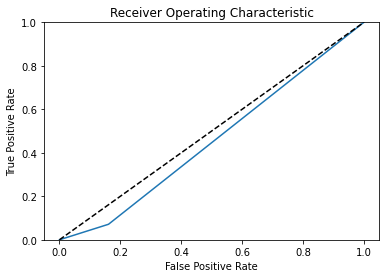

In [541]:
predictions = model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

print(y_pred)
print(y_test, '\n')

evaluate_on_training_set(y_test, y_pred)

# k cross

In [542]:
def k_cross(model, X=X_train, y=y_train, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

# Evaluation

In [543]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred)
    print(y_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Logistic Regression

In [544]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"power: {i}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"power: {i}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_logreg_f1_model, best_logreg_recall_model = find_best_logreg_model(6)

power: 0: f1 = 0.0 > best f1 = -1
power: 0: recall = 0.0 > best recall = -1


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        31
           1       0.00      0.00      0.00        14

    accuracy                           0.69        45
   macro avg       0.34      0.50      0.41        45
weighted avg       0.47      0.69      0.56        45

Confusion Matrix: 
 [[31  0]
 [14  0]]


C:\Users\65842\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(C=1, n_jobs=3)

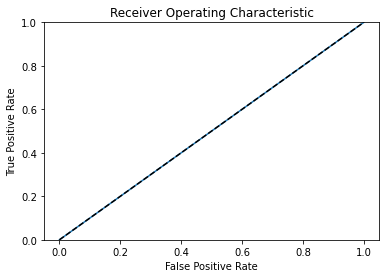

In [545]:
# Based on f1
evaluate_model(best_logreg_f1_model)

# Decision Tree

In [546]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.0 > best f1 = -1
depth: 1, leaf: 1: recall = 0.0 > best recall = -1
depth: 1, leaf: 15: f1 = 0.03333333333333333 > best f1 = 0.0
depth: 1, leaf: 15: recall = 0.025 > best recall = 0.0
depth: 2, leaf: 1: f1 = 0.050793650793650794 > best f1 = 0.03333333333333333
depth: 2, leaf: 1: recall = 0.041666666666666664 > best recall = 0.025
depth: 2, leaf: 5: f1 = 0.05357142857142858 > best f1 = 0.050793650793650794
depth: 2, leaf: 8: f1 = 0.07857142857142858 > best f1 = 0.05357142857142858
depth: 2, leaf: 8: recall = 0.055952380952380955 > best recall = 0.041666666666666664
depth: 2, leaf: 18: recall = 0.06666666666666667 > best recall = 0.055952380952380955
depth: 3, leaf: 5: f1 = 0.09047619047619049 > best f1 = 0.07857142857142858
depth: 3, leaf: 5: recall = 0.075 > best recall = 0.06666666666666667
depth: 3, leaf: 8: f1 = 0.15357142857142858 > best f1 = 0.09047619047619049
depth: 3, leaf: 8: recall = 0.13452380952380955 > best recall = 0.075
depth: 3, leaf: 12: f1 = 

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.6463133640552996
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        31
           1       0.71      0.36      0.48        14

    accuracy                           0.76        45
   macro avg       0.74      0.65      0.66        45
weighted avg       0.75      0.76      0.73        45

Confusion Matrix: 
 [[29  2]
 [ 9  5]]


DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=42)

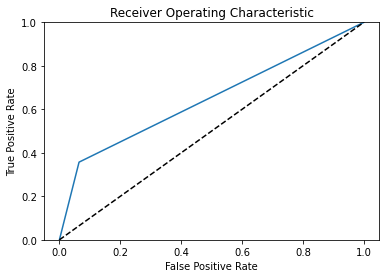

In [547]:
# Based on f1
evaluate_model(best_tree_f1_model)

[0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 1 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.4746543778801843
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        31
           1       0.25      0.14      0.18        14

    accuracy                           0.60        45
   macro avg       0.46      0.47      0.46        45
weighted avg       0.54      0.60      0.56        45

Confusion Matrix: 
 [[25  6]
 [12  2]]


DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, random_state=42)

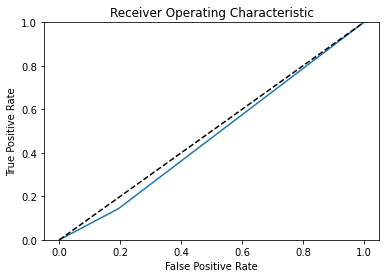

In [548]:
# Based on recall
evaluate_model(best_tree_recall_model)

# RF

In [549]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.24254689754689757 > best f1 = -1
estimator: 1: recall = 0.24095238095238095 > best recall = -1


[1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0
 1 1 0 1 0 1 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.48502304147465436
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        31
           1       0.29      0.36      0.32        14

    accuracy                           0.53        45
   macro avg       0.49      0.49      0.48        45
weighted avg       0.56      0.53      0.54        45

Confusion Matrix: 
 [[19 12]
 [ 9  5]]


RandomForestClassifier(n_estimators=1, random_state=42)

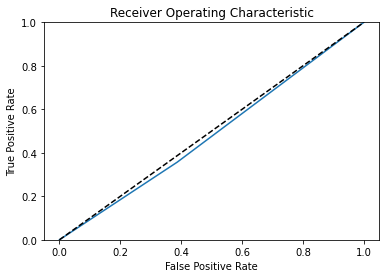

In [550]:
# Based on f1
evaluate_model(best_forest_f1_model)

[1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0
 1 1 0 1 0 1 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.48502304147465436
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        31
           1       0.29      0.36      0.32        14

    accuracy                           0.53        45
   macro avg       0.49      0.49      0.48        45
weighted avg       0.56      0.53      0.54        45

Confusion Matrix: 
 [[19 12]
 [ 9  5]]


RandomForestClassifier(n_estimators=1, random_state=42)

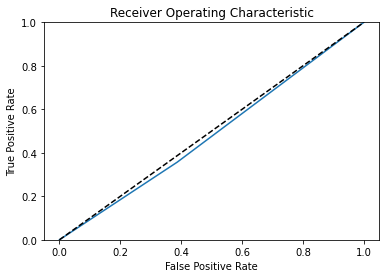

In [551]:
# Based on recall
evaluate_model(best_forest_recall_model)

# SVM with Grid Search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.2s finished
C:\Users\65842\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        31
           1       0.00      0.00      0.00        14

    accuracy                           0.69        45
   macro avg       0.34      0.50      0.41        45
weighted avg       0.47      0.69      0.56        45

Confusion Matrix: 
 [[31  0]
 [14  0]]
Best SVM parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


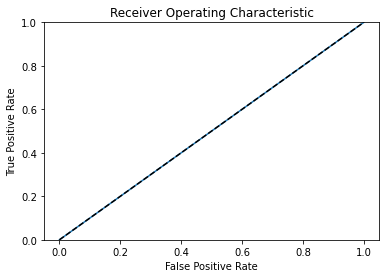

In [552]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")